# SYDE 675 - Final Project

**Winter 2021 - Group 11**

# Import Required Packages

In [ ]:
# upgrade sklearn and imblearn to avoid errors
!pip install --upgrade scikit-learn imbalanced-learn torchsummary

     |████████████████████████████████| 22.3MB 1.5MB/s 
     |████████████████████████████████| 215kB 45.1MB/s 
Requirement already up-to-date: torchsummary in /usr/local/lib/python3.7/dist-packages (1.5.1)
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import collections
import random
from sklearn.utils.class_weight import compute_class_weight
from scipy import stats
from imblearn.over_sampling import RandomOverSampler,BorderlineSMOTE, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


# Download the Dataset

Below are instructions for how to download the cell2cell dataset directly from kaggle using the kaggle api. However, this requires authentication, so for simplicity, we have also uploaded the dataset to an Azure hosting and download it from there for convenience.

## Download dataset directly from Kaggle

In [ ]:
# ! pip install kaggle --upgrade

Kaggle requires an authentication token for approval to download. After making a Kaggle account, see [https://www.kaggle.com/docs/api](https://www.kaggle.com/docs/api#authentication) for how to download the kaggle.json file with your username and authentication key. This file should be placed at `~/.kaggle/kaggle.json`, or alternatively the username and key can be passed as environment variables using the commands below. These can be found in the json file.

```bash
export KAGGLE_USERNAME=user
export KAGGLE_KEY=xxxxxxxxxxxxxx
```

The command below will download the Telecom Churn dataset from Teradata center for customer relationship management at Duke University from its hosting on Kaggle. See the dataset at the link below:

[Kaggle: telecom churn- new cell2cell dataset](https://www.kaggle.com/jpacse/telecom-churn-new-cell2cell-dataset)

In [ ]:
# ! kaggle datasets download -d jpacse/telecom-churn-new-cell2cell-dataset

## Download dataset from Azure hosting

We have temporarily uploaded the dataset to Microsoft Azure for easier download without authentication. The command below will download it into colab directly. The dataset will be hosted on Azure for the duration of the project.

In [ ]:
%%bash
# Only download dataset if it hasn't been done already
if [ ! -f "cell2cell-duke univeristy.csv" ]; then
    wget "https://syde675gr11.blob.core.windows.net/cell2cell/cell2cell-duke%20univeristy.csv"
fi

--2021-04-22 23:19:35--  https://syde675gr11.blob.core.windows.net/cell2cell/cell2cell-duke%20univeristy.csv
Resolving syde675gr11.blob.core.windows.net (syde675gr11.blob.core.windows.net)... 52.239.190.36
Connecting to syde675gr11.blob.core.windows.net (syde675gr11.blob.core.windows.net)|52.239.190.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19744061 (19M) [application/vnd.ms-excel]
Saving to: ‘cell2cell-duke univeristy.csv’

     0K .......... .......... .......... .......... ..........  0%  361K 53s
    50K .......... .......... .......... .......... ..........  0%  721K 40s
   100K .......... .......... .......... .......... ..........  0%  722K 35s
   150K .......... .......... .......... .......... ..........  1%  228M 26s
   200K .......... .......... .......... .......... ..........  1%  723K 26s
   250K .......... .......... .......... .......... ..........  1%  267M 22s
   300K .......... .......... .......... .......... ..........  1%  724K 2

# Dataset Preprocessing

In [ ]:
# Import the dataset
data = pd.read_csv('cell2cell-duke univeristy.csv')
# Print number of churn/no-churn in original dataset
print('Dataset Length:\t{}'.format(data.shape[0]))
print('# of Churn:    \t{}'.format(sum(data['churn'] == 1)))
print('# of Non-Churn:\t{}'.format(sum(data['churn'] == 0)))

cols_with_null = []

for column in data:
    # Find columns that have null or missing values
    if data[column].isnull().any():
        cols_with_null.append(column)
        
print('cols_with_null ({}): {}'.format(len(cols_with_null), cols_with_null))

pd.options.display.max_columns = None
pd.options.display.max_rows = None

Dataset Length:	71047
# of Churn:    	20609
# of Non-Churn:	50438
cols_with_null (14): ['churndep', 'revenue', 'mou', 'recchrge', 'directas', 'overage', 'roam', 'changem', 'changer', 'phones', 'models', 'eqpdays', 'age1', 'age2']


In [ ]:
# The following columns will be dropped as they provide no useful information
# The first two columns ('Unnamed: 0' and 'X') are simply the row index
# The 'customer' column contains a unique customer ID
# The 'traintest' column is whether the row is part of the training set. We will make our own
# train/test splits.
# The 'churndep' column is a duplicate of the churn column where it has null values
# for the testset rows
df = data.drop(columns=['Unnamed: 0','X','customer','traintest','churndep'])

# Count number of null values in each row
count = collections.Counter(df.isnull().sum(axis=1))
print(count)

Counter({0: 69309, 2: 1518, 8: 210, 10: 6, 4: 3, 3: 1})


In [ ]:
# Remove all rows that have null for more than 7 variables
df = df.dropna(axis=0, thresh=df.shape[1]-7)

# split into X and y variables
X, y = df.drop(columns='churn'), df['churn']
print('X shape', X.shape)
print('y shape', y.shape)

X shape (70831, 66)
y shape (70831,)


In [ ]:
# Show features that still contain NA values
df.isna().sum()

churn          0
revenue        0
mou            0
recchrge       0
directas       0
overage        0
roam           0
changem      286
changer      286
dropvce        0
blckvce        0
unansvce       0
custcare       0
threeway       0
mourec         0
outcalls       0
incalls        0
peakvce        0
opeakvce       0
dropblk        0
callfwdv       0
callwait       0
months         0
uniqsubs       0
actvsubs       0
phones         1
models         1
eqpdays        1
age1        1238
age2        1238
children       0
credita        0
creditaa       0
prizmrur       0
prizmub        0
prizmtwn       0
refurb         0
webcap         0
truck          0
rv             0
occprof        0
occcler        0
occcrft        0
occstud        0
occhmkr        0
occret         0
occself        0
ownrent        0
marryun        0
marryyes       0
mailord        0
mailres        0
mailflag       0
travel         0
pcown          0
creditcd       0
retcalls       0
retaccpt       0
newcelly      

In [ ]:
# Find columns that still contain null values
cols_with_null = []

for column in X:
    # Find columns that have null or missing values
    if X[column].isnull().any():
        cols_with_null.append(column)
        
print('cols_with_null ({}): {}'.format(len(cols_with_null), cols_with_null))

cols_with_null (7): ['changem', 'changer', 'phones', 'models', 'eqpdays', 'age1', 'age2']


In [ ]:
# Use simple imputer to convert null values to 0
# Note that this will return an ndarray, not a pandas dataframe
# imp_const = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
# X = imp_const.fit_transform(X)

# Convert all null values to 0 using pandas
X = X.fillna(0)

# Count number of null values in each row
count = collections.Counter(X.isnull().sum(axis=1))
print(count)

X.info()

Counter({0: 70831})
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70831 entries, 0 to 71042
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   revenue   70831 non-null  float64
 1   mou       70831 non-null  float64
 2   recchrge  70831 non-null  float64
 3   directas  70831 non-null  float64
 4   overage   70831 non-null  float64
 5   roam      70831 non-null  float64
 6   changem   70831 non-null  float64
 7   changer   70831 non-null  float64
 8   dropvce   70831 non-null  float64
 9   blckvce   70831 non-null  float64
 10  unansvce  70831 non-null  float64
 11  custcare  70831 non-null  float64
 12  threeway  70831 non-null  float64
 13  mourec    70831 non-null  float64
 14  outcalls  70831 non-null  float64
 15  incalls   70831 non-null  float64
 16  peakvce   70831 non-null  float64
 17  opeakvce  70831 non-null  float64
 18  dropblk   70831 non-null  float64
 19  callfwdv  70831 non-null  float64
 20  callwait

## Standardize Data

In [ ]:
def baseline_model_acc(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    # rf = RandomForestClassifier(n_estimators=500, class_weight='balanced')
    y_pred = lr.predict(X_val)
    y_pred_prob = lr.predict_proba(X_val)[:,1]
    print(np.unique(y_val, return_counts=True), np.unique(y_pred, return_counts=True))
    print('acc:', metrics.accuracy_score(y_true=y_val, y_pred=y_pred))
    print('roc auc:', metrics.roc_auc_score(y_val, y_pred_prob))
    print('precision, recall, fscore:', metrics.precision_recall_fscore_support(y_val, y_pred))

    y_pred_train = lr.predict(X_train)
    print('Training acc:', metrics.accuracy_score(y_true=y_train, y_pred=y_pred_train))
    return metrics.roc_auc_score(y_val, y_pred_prob)

# Find non-binary columns
non_binary = []

for column in X:
    if len(X[column].unique()) > 2:
        non_binary.append(column)
        
print('non_binary ({}): {}'.format(len(non_binary), non_binary))

non_binary (34): ['revenue', 'mou', 'recchrge', 'directas', 'overage', 'roam', 'changem', 'changer', 'dropvce', 'blckvce', 'unansvce', 'custcare', 'threeway', 'mourec', 'outcalls', 'incalls', 'peakvce', 'opeakvce', 'dropblk', 'callfwdv', 'callwait', 'months', 'uniqsubs', 'actvsubs', 'phones', 'models', 'eqpdays', 'age1', 'age2', 'retcalls', 'retaccpt', 'refer', 'income', 'setprc']


In [ ]:
# Logistic performance before standardization
auc0 = baseline_model_acc(X,y)

(array([0, 1]), array([10035,  4132])) (array([0, 1]), array([14022,   145]))
acc: 0.7071363026752312
roc auc: 0.6168600122224682
precision, recall, fscore: (array([0.70988447, 0.44137931]), array([0.99192825, 0.01548887]), array([0.82753461, 0.02992752]), array([10035,  4132]))
Training acc: 0.7110864040660737


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Test performance with mean and variance standardization
non_binary_feats = X[non_binary]
scalar = StandardScaler(with_mean=True,with_std=True)
standard_feats = scalar.fit_transform(non_binary_feats.values)
X1 = X.copy()
X1[non_binary] = standard_feats

# Logistic performance with zero mean and variance standardization
auc1 = baseline_model_acc(X1,y)

(array([0, 1]), array([10035,  4132])) (array([0, 1]), array([13867,   300]))
acc: 0.7086186207383356
roc auc: 0.6213706287432514
precision, recall, fscore: (array([0.71298767, 0.50666667]), array([0.98525162, 0.03678606]), array([0.82729479, 0.06859206]), array([10035,  4132]))
Training acc: 0.7120923337568826


In [ ]:
# Test performance with min max scaler
non_binary_feats = X[non_binary]
mm_scaler = MinMaxScaler(feature_range=(0,1))
min_max_feats = mm_scaler.fit_transform(non_binary_feats.values)
X2 = X.copy()
X2[non_binary] = min_max_feats

# Logistic performance with min max scaler
auc2 = baseline_model_acc(X2,y)

(array([0, 1]), array([10035,  4132])) (array([0, 1]), array([13912,   255]))
acc: 0.7092538999082375
roc auc: 0.61595562674878
precision, recall, fscore: (array([0.7126222, 0.5254902]), array([0.9879422 , 0.03242982]), array([0.82799516, 0.06108958]), array([10035,  4132]))
Training acc: 0.7116864323026966


## Train test split

In [ ]:
# Make a train test split
X = X2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Dataset Sampling Methods

In [ ]:
def rf_train_test_split_sampler(sampler, ratio=1.0):
  sample = sampler(sampling_strategy=ratio)

  X_train_sampled, y_train_sampled = sample.fit_resample(X_train, y_train) 
  rf = RandomForestClassifier(n_estimators=500, random_state=0, criterion='gini')
  rf.fit(X_train_sampled, y_train_sampled)
  y_pred = rf.predict(X_val)
  y_pred_prob = rf.predict_proba(X_val)[:,1]

  print(np.unique(y_val, return_counts=True), np.unique(y_pred, return_counts=True))
  print('acc:', metrics.accuracy_score(y_true=y_val, y_pred=y_pred))
  print('roc auc:', metrics.roc_auc_score(y_val, y_pred_prob))
  print('precision, recall, fscore:', metrics.precision_recall_fscore_support(y_val, y_pred))

In [ ]:
def CV_Kfold_5(sampler, sampling, testing_model, X, y, ratio = 1.0):
    # Initialize the lists 
    acc_scores, auc_scores, p_scores, r_scores, f_scores, kf = [], [], [], [], [], 0

    # Initialize the Kfolds
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Iterate through Kfold indexes 
    for train_index, test_index in folds.split(X, y):

      # Initialize the data based on Kfold index
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # if sampling apply sampler
      if sampling:
        X_train, y_train = sampler(sampling_strategy=ratio).fit_resample(X_train, y_train)
      
      # Set model we are testing to model parameter so it retrains the model new for each Kfold
      model = testing_model

      print('Fitting')
 

      # Fit model to the data and predict 
      model.fit(X_train, y_train)

      print('Predicting')
      

      y_pred = model.predict(X_test)
      y_pred_prob = model.predict_proba(X_test)[:,1]

      print('Obtaining metric')

      p_score, r_score, f_score, _ = metrics.precision_recall_fscore_support(y_test, y_pred)

      # append metric scores to a list 
      acc_scores.append(metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
      auc_scores.append(metrics.roc_auc_score(y_test, y_pred_prob))
      p_scores.append(p_score[1])
      r_scores.append(r_score[1])
      f_scores.append(f_score[1])

      # Print the fold of each loop
      kf += 1
      print('KFold ' + str(kf) + ' completed')

    # return the metric lists, min, max, and mean 
    mean_acc = np.mean(acc_scores)
    mean_auc = np.mean(auc_scores)
    mean_p = np.mean(p_scores)
    mean_r = np.mean(r_scores)
    mean_f = np.mean(f_scores)

    min_acc = np.min(acc_scores)
    min_auc = np.min(auc_scores)
    min_p = np.min(p_scores)
    min_r = np.min(r_scores)
    min_f = np.min(f_scores)

    max_acc = np.max(acc_scores)
    max_auc = np.max(auc_scores)
    max_p = np.max(p_scores)
    max_r = np.max(r_scores)
    max_f = np.max(f_scores)

    # Create Dictionaries of the 5 metrics and their min, mean, max
    acc = {'Accuracy': acc_scores, 'mean' : mean_acc, 'min' : min_acc, 'max' : max_acc}
    auc = {'AUC': auc_scores, 'mean' : mean_auc, 'min' : min_auc, 'max' : max_auc}
    precision = {'Precision': p_scores, 'mean' : mean_p, 'min' : min_p, 'max' : max_p}
    recall = {'Recall': r_scores, 'mean' : mean_r, 'min' : min_r, 'max' : max_r}
    f_score = {'F_score': f_scores, 'mean' : mean_f, 'min' : min_f, 'max' : max_f}

    return acc, auc, precision, recall, f_score

## Oversampling with Borderline SMOTE

sampling test with train test split instead of cross validation

In [ ]:
oversample = BorderlineSMOTE(sampling_strategy=0.67)
X_train_bsmote, y_train_bsmote = oversample.fit_resample(X_train, y_train)
rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =0, max_features = "auto",
                                  max_leaf_nodes = 80)
rf.fit(X_train_bsmote, y_train_bsmote)
y_pred = rf.predict(X_val)
y_pred_prob = rf.predict_proba(X_val)[:,1]
print(np.unique(y_val, return_counts=True), np.unique(y_pred, return_counts=True))
print('acc:', metrics.accuracy_score(y_true=y_val, y_pred=y_pred))
print('roc auc:', metrics.roc_auc_score(y_val, y_pred_prob))
print('precision, recall, fscore:', metrics.precision_recall_fscore_support(y_val, y_pred))

(array([0, 1]), array([10035,  4132])) (array([0, 1]), array([13737,   430]))
acc: 0.7081951012917344
roc auc: 0.6515505749238748
precision, recall, fscore: (array([0.71478489, 0.49767442]), array([0.97847534, 0.0517909 ]), array([0.82609793, 0.0938185 ]), array([10035,  4132]))


In [ ]:
for i in [3/7, 0.67, 1]:
  rf_train_test_split_sampler(BorderlineSMOTE, ratio=i)

## Oversampling with SMOTE

In [ ]:
for i in [3/7, 0.67, 1.0]:
  rf_train_test_split_sampler(SMOTE, ratio=i)

## Random Oversampling

In [ ]:
for i in [3/7, 0.67, 1.0]:
  rf_train_test_split_sampler(RandomOverSampler, ratio=i)

## Random Undersampling

In [ ]:
for i in [3/7, 0.67, 1.0]:
  rf_train_test_split_sampler(RandomUnderSampler, ratio=i)

In [ ]:
undersample = RandomUnderSampler(sampling_strategy=1)
X_under, y_under = undersample.fit_resample(X, y) 
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_under, y_under, test_size=0.2, random_state=0)

# Logistic Regression

## LR Hyperparameter Tuning

In [ ]:
# Set a parameter dictionary for the GridSearch,
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
              'C': [0.1, 0.01, 1, 2, 10], 
              'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
         }

# Call the model function 
lr = LogisticRegression()

# Set GridSearch on a cv = 5
lr_cv_model = GridSearchCV(lr, params, cv = 5)

# Fit the Gridsearch model to find the opitmal parameters
lr_cv_model.fit(X_train, y_train)

# Print out the best parameter set 
print("Best Parameters : ",lr_cv_model.best_params_)

In [ ]:
lr_cv_model.best_params_

{'C': 0.1, 'penalty': 'none', 'solver': 'newton-cg'}

## LR Model No Sampling

In [ ]:
# lr no sampler 
lr = LogisticRegression(random_state=0, solver='newton-cg', penalty='none')

lr_base_metrics = CV_Kfold_5(None, None, lr, X, y, ratio = 1.0)
# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_val)
# y_pred_prob = lr.predict_proba(X_val)[:,1]
# print(np.unique(y_val, return_counts=True), np.unique(y_pred, return_counts=True))
# print('acc:', metrics.accuracy_score(y_true=y_val, y_pred=y_pred))
# print('roc auc:', metrics.roc_auc_score(y_val, y_pred_prob))
# print('precision, recall, fscore:', metrics.precision_recall_fscore_support(y_val, y_pred))

Fitting
Predicting
Obtaining metric
KFold 1 completed
Fitting
Predicting
Obtaining metric
KFold 2 completed
Fitting
Predicting
Obtaining metric
KFold 3 completed
Fitting
Predicting
Obtaining metric
KFold 4 completed
Fitting
Predicting
Obtaining metric
KFold 5 completed


In [ ]:
lr_base_metrics

({'Accuracy': [0.7117950165878449,
   0.710856981505012,
   0.7104334321615134,
   0.7090921925737682,
   0.7122688126500071],
  'max': 0.7122688126500071,
  'mean': 0.7108892870956292,
  'min': 0.7090921925737682},
 {'AUC': [0.6132724457497852,
   0.6124962675552097,
   0.6203935090044436,
   0.6136105802408705,
   0.6150036709692293],
  'max': 0.6203935090044436,
  'mean': 0.6149552947039076,
  'min': 0.6124962675552097},
 {'Precision': [0.53515625,
   0.5092250922509225,
   0.4978540772532189,
   0.4647887323943662,
   0.5550660792951542],
  'max': 0.5550660792951542,
  'mean': 0.5124180462387323,
  'min': 0.4647887323943662},
 {'Recall': [0.03340648622287247,
   0.033650329188002925,
   0.028285783955132895,
   0.03218727139722019,
   0.030724213606437453],
  'max': 0.033650329188002925,
  'mean': 0.03165081687393319,
  'min': 0.028285783955132895},
 {'F_score': [0.06288730778058298,
   0.06312900274473925,
   0.05353022611905861,
   0.06020524515393387,
   0.05822550831792977],
  

## LR Model 1:1 Undersampling

In [ ]:
# lr under sampler 
# lr = LogisticRegression(max_iter=1000, random_state=0)
lr = LogisticRegression(random_state=0, solver='newton-cg', penalty='none')

lr_under_metrics = CV_Kfold_5(RandomUnderSampler, True, lr, X, y, ratio = 1.0)
# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_val)
# y_pred_prob = lr.predict_proba(X_val)[:,1]
# print(np.unique(y_val, return_counts=True), np.unique(y_pred, return_counts=True))
# print('acc:', metrics.accuracy_score(y_true=y_val, y_pred=y_pred))
# print('roc auc:', metrics.roc_auc_score(y_val, y_pred_prob))
# print('precision, recall, fscore:', metrics.precision_recall_fscore_support(y_val, y_pred))

Fitting
Predicting
Obtaining metric
KFold 1 completed
Fitting
Predicting
Obtaining metric
KFold 2 completed
Fitting
Predicting
Obtaining metric
KFold 3 completed
Fitting
Predicting
Obtaining metric
KFold 4 completed
Fitting
Predicting
Obtaining metric
KFold 5 completed


In [ ]:
lr_under_metrics

({'Accuracy': [0.5875626455848098,
   0.5861922914019483,
   0.5907807426231823,
   0.5814626570662149,
   0.5852746011577016],
  'max': 0.5907807426231823,
  'mean': 0.5862545875667713,
  'min': 0.5814626570662149},
 {'AUC': [0.6184452789594044,
   0.6170951967538966,
   0.6254790096995716,
   0.6161056279755838,
   0.6166114840224713],
  'max': 0.6254790096995716,
  'mean': 0.6187473194821855,
  'min': 0.6161056279755838},
 {'Precision': [0.3653370439084725,
   0.3667322536703496,
   0.37124202854539934,
   0.36067073170731706,
   0.36311728395061726],
  'max': 0.37124202854539934,
  'mean': 0.3654198683564312,
  'min': 0.36067073170731706},
 {'Recall': [0.5762009266032675,
   0.5908315045110949,
   0.5961960497439649,
   0.5769324554986589,
   0.5737624969519629],
  'max': 0.5961960497439649,
  'mean': 0.5827846866617898,
  'min': 0.5737624969519629},
 {'F_score': [0.4471567792601003,
   0.45255883451624956,
   0.45756526621128474,
   0.4438608010505581,
   0.4447594745298176],
  'm

# Random Forest Model

In [ ]:
# random forest
rf = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced_subsample')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
y_pred_prob = rf.predict_proba(X_val)[:,1]

print(np.unique(y_val, return_counts=True), np.unique(y_pred, return_counts=True))
print('acc:', metrics.accuracy_score(y_true=y_val, y_pred=y_pred))
print('roc auc:', metrics.roc_auc_score(y_val, y_pred_prob))
print('precision, recall, fscore:', metrics.precision_recall_fscore_support(y_val, y_pred))

(array([0, 1]), array([10035,  4132])) (array([0, 1]), array([13773,   394]))
acc: 0.7132773346509493
roc auc: 0.6769577533810752
precision, recall, fscore: (array([0.71683729, 0.58883249]), array([0.9838565 , 0.05614714]), array([0.82938508, 0.10251878]), array([10035,  4132]))


## RF Hyperparameter Tuning

In [ ]:
# Set a parameter dictionary for the GridSearch, these are just prelimiary 
params = { 
                'n_estimators' : [500,100, 1000],
                'max_leaf_nodes': [50,100, None],
                'max_features' : ('log2', 'sqrt')
              }

# Call the model function 
rf = RandomForestClassifier(n_jobs = -1, random_state =0, oob_score=True)
# Set GridSearch on a cv = 5
rf_cv_model = GridSearchCV(rf, params, cv = 3, scoring='roc_auc', verbose=1)

# Fit the Gridsearch model to find the opitmal parameters
rf_cv_model.fit(X_train_under, y_train_under)

# Print out the best parameter set 
print("Best Parameters : ",rf_cv_model.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters :  {'max_features': 'sqrt', 'max_leaf_nodes': None, 'n_estimators': 1000}


## RF Model No Sampling 

In [ ]:
# rf no sampler 
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_base_metrics = CV_Kfold_5(None, None, rf, X, y, ratio = 1.0)

Fitting
Predicting
Obtaining metric
KFold 1 completed
Fitting
Predicting
Obtaining metric
KFold 2 completed
Fitting
Predicting
Obtaining metric
KFold 3 completed
Fitting
Predicting
Obtaining metric
KFold 4 completed
Fitting
Predicting
Obtaining metric
KFold 5 completed


In [ ]:
rf_base_metrics

({'Accuracy': [0.7180066351379968,
   0.7200338839474799,
   0.7167866723139913,
   0.7194691514894819,
   0.7173514047719892],
  'max': 0.7200338839474799,
  'mean': 0.7183295495321877,
  'min': 0.7167866723139913},
 {'AUC': [0.6754266391923037,
   0.6698802213798556,
   0.6773562552988603,
   0.6732086354569475,
   0.6691994719037304],
  'max': 0.6773562552988603,
  'mean': 0.6730142446463395,
  'min': 0.6691994719037304},
 {'Precision': [0.6086065573770492,
   0.6256983240223464,
   0.591002044989775,
   0.626746506986028,
   0.6025369978858351],
  'max': 0.626746506986028,
  'mean': 0.6109180862522068,
  'min': 0.591002044989775},
 {'Recall': [0.07242136064374542,
   0.08193123628383321,
   0.07047061692270178,
   0.07656669105096318,
   0.06949524506217995],
  'max': 0.08193123628383321,
  'mean': 0.07417702999268472,
  'min': 0.06949524506217995},
 {'F_score': [0.12943996513401612,
   0.1448900388098318,
   0.1259259259259259,
   0.13646240764884834,
   0.12461740271097507],
  'm

## RF Model 1:1 Undersampling

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_under_metrics = CV_Kfold_5(RandomUnderSampler, True, rf, X, y, ratio = 1.0)

Fitting
Predicting
Obtaining metric
KFold 1 completed
Fitting
Predicting
Obtaining metric
KFold 2 completed
Fitting
Predicting
Obtaining metric
KFold 3 completed
Fitting
Predicting
Obtaining metric
KFold 4 completed
Fitting
Predicting
Obtaining metric
KFold 5 completed


In [ ]:
rf_under_metrics

({'Accuracy': [0.6113503211689136,
   0.609134547508118,
   0.6125229422561062,
   0.6117464351263588,
   0.6092757306226175],
  'max': 0.6125229422561062,
  'mean': 0.6108059953364229,
  'min': 0.609134547508118},
 {'AUC': [0.6718686660723934,
   0.6706145605866187,
   0.6736214362798842,
   0.6729973533408122,
   0.6673585725944007],
  'max': 0.6736214362798842,
  'mean': 0.6712921177748218,
  'min': 0.6673585725944007},
 {'Precision': [0.39621805288816664,
   0.3936611374407583,
   0.3963560334528076,
   0.3967832374206876,
   0.39317640047675806],
  'max': 0.3967832374206876,
  'mean': 0.39523897233583566,
  'min': 0.39317640047675806},
 {'Recall': [0.653986832479883,
   0.648134601316752,
   0.6471592294562302,
   0.6556937332357962,
   0.6435015849792733],
  'max': 0.6556937332357962,
  'mean': 0.6496951962935871,
  'min': 0.6435015849792733},
 {'F_score': [0.49346826126954924,
   0.48981848336865386,
   0.49161804204871723,
   0.49439235153520866,
   0.48811615647831313],
  'max

# SVM

In [ ]:
svc = SVC(C=4.17, gamma=0.03, kernel='linear', probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)
y_pred_prob = svc.predict_proba(X_val)[:,1]

print(np.unique(y_val, return_counts=True), np.unique(y_pred, return_counts=True))
print('acc:', metrics.accuracy_score(y_true=y_val, y_pred=y_pred))
print('roc auc:', metrics.roc_auc_score(y_val, y_pred_prob))
print('precision, recall, fscore:', metrics.precision_recall_fscore_support(y_val, y_pred))

# ANN Model using PyTorch

In [ ]:
# Load pytorch packages
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose
from torchsummary import summary
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler

# Check if cpu or gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
# Define the ANN network using pytorch

# function for initializing weights in model
def weights_init(m):
    if isinstance(m, nn.Linear):
        # This is the default pytorch initialization
        stdv = 1. / np.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -stdv, stdv)
        if m.bias is not None:
            nn.init.uniform_(m.bias, -stdv, stdv)

# ANN structure creation
class NeuralNetwork(nn.Module):
    def __init__(self, in_size, h_sizes, sigmoid=True):
        super(NeuralNetwork, self).__init__()
        self.in_size = in_size
        self.h_sizes = h_sizes
        self.layer_stack = nn.Sequential()
        self.sigmoid = sigmoid

        # Add first linear layer and ReLU Activation
        self.layer_stack.add_module("linear_0", 
            nn.Linear(self.in_size, self.h_sizes[0]))
        self.layer_stack.add_module("relu_0", nn.ReLU())

        for i in range(len(h_sizes)-1):
            # Add hidden linear layer and ReLU Activation
            self.layer_stack.add_module("linear_"+str(i+1), 
                nn.Linear(self.h_sizes[i], self.h_sizes[i+1]))
            self.layer_stack.add_module("relu_"+str(i+1), nn.ReLU())

        if sigmoid:
            # Add final linear layer, will output 1 node with sigmoid
            self.layer_stack.add_module("linear_"+str(len(h_sizes)), 
                nn.Linear(self.h_sizes[-1], 1))
            self.layer_stack.add_module("sigmoid_out", nn.Sigmoid())
        else:
            # Add final linear layer, will output 2 nodes
            self.layer_stack.add_module("linear_"+str(len(h_sizes)), 
                nn.Linear(self.h_sizes[-1], 2))
            # No activation function is used as softmax is included within the 
            # CrossEntropyLoss() loss function
    def forward(self, x):
        output = self.layer_stack(x)
        return output

sigmoid_out = True

# Create sample model
model = NeuralNetwork(66,[32], sigmoid_out).to(device) # send to cpu or gpu
model.apply(weights_init) # Apply weight initialization
print('Printout of model:')
print(model)

# Define loss function
if sigmoid_out:
    # Use Binary cross entropy loss if using sigmoid on one output node
    loss_fn = nn.BCELoss()
else:
    # Combined softmax with negative log likelihood loss
    loss_fn = nn.CrossEntropyLoss()

# Use torchsummary
print('Torchsummary Summary:')
summary(model, input_size=(66,))

Printout of model:
NeuralNetwork(
  (layer_stack): Sequential(
    (linear_0): Linear(in_features=66, out_features=32, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid_out): Sigmoid()
  )
)
Torchsummary Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           2,144
              ReLU-2                   [-1, 32]               0
            Linear-3                    [-1, 1]              33
           Sigmoid-4                    [-1, 1]               0
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


## Loading the dataset by batches

The following will split the dataset into batches for training, however this may be unnecessary as the entire dataset can fit into memory at once. This is just to show how it is done. Note that loading by batches as shown below is much slower due to looping over the ChurnDataset class many times.

In [ ]:
# Create custom PyTorch dataset
class ChurnDataset(Dataset):
    def __init__(self, X_data, y_data, transform=None):
        self.transform = transform
        self.X_data = X_data.to_numpy()
        self.y_data = y_data.to_numpy()
        
    def __len__(self):
        return self.X_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        rows = self.X_data[idx].astype('float')
        churn = self.y_data[idx].astype('float')
        
        rows = torch.FloatTensor(rows)
        churn = torch.FloatTensor(churn)
            
        return (rows, churn)

def getBatchLoader(X_data, y_data, batch_size = 1000, randomSample = False):
    # Function to get pytorch batch dataloader from X, y data
    pydataset = ChurnDataset(X_data, y_data)

    # The BatchSampler will return multiple indices at once based on batch_size
    if randomSample:
        # RandomSampler uses a random order for the samples
        return DataLoader(pydataset, 
                  sampler=BatchSampler(RandomSampler(pydataset), 
                  batch_size=batch_size, drop_last=False), num_workers=0)
    else:
        # The sequential sampler will ensure the result predictions 
        # are in the same order as the input arrays to the dataloader
        return DataLoader(pydataset, 
                  sampler=BatchSampler(SequentialSampler(pydataset), 
                  batch_size=batch_size, drop_last=False), num_workers=0)

## ANN Train and Test functions

In [ ]:
# The following is adapted from pytorch's quickstart guide available below:
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

# Define the training function (one epoch)
def ann_train_batch(dataloader, model, loss_fn, optimizer, threshold = 0.5):
    # get total size of dataset
    data_size = len(dataloader.dataset)
    loader_size = len(dataloader)
    
    model.train()
    total_loss, accuracy = 0, 0
    if model.sigmoid:
        y_prob_total = np.empty(0)
    else:
        y_prob_total = np.empty((0,2))
    y_pred_total = np.empty(0)
    for batch, (X, y) in enumerate(dataloader):
        # Move X and y to proper device
        X_train, y_train = X.to(device), y.to(device)
        y_train = y_train.squeeze()
        
        if model.sigmoid == False:
            y_data = y_data.long()

        # Calculate the current loss
        output = model(X_train).squeeze()
        loss = loss_fn(output, y_train)
        total_loss += loss.item()
        
        # Perform weight update
        optimizer.zero_grad() # reset gradients
        loss.backward() # calculate gradients
        optimizer.step() # update weights

        if model.sigmoid == True:
            # Assume sigmoid output node
            y_pred = (output > threshold).squeeze()
            y_prob = output
        else:
            # Assume 2 node output requiring softmax
            # Calculate the probabilities
            y_prob = nn.functional.softmax(output,dim=1)
            # get churn prediction
            y_pred = torch.argmax(y_prob, dim=1).squeeze()
            y_prob = y_prob[:,1]

        # Calculate the prediction accuracy
        accuracy += (y_pred == y_train).type(torch.float).sum().item()

        y_prob = y_prob.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()

        y_prob_total = np.append(y_prob_total, y_prob, axis=0)
        y_pred_total = np.append(y_pred_total, y_pred)

    # Calculate final accuracy
    accuracy /= data_size
    total_loss /= loader_size

    return total_loss, accuracy, y_prob_total, y_pred_total.astype('int')

# Define the test function
def ann_test_batch(dataloader, model, threshold = 0.5):
    # get total size of dataset
    data_size = len(dataloader.dataset)
    loader_size = len(dataloader)
    
    model.eval()
    total_loss, accuracy = 0, 0
    if model.sigmoid:
        y_prob_total = np.empty(0)
    else:
        y_prob_total = np.empty((0,2))
    y_pred_total = np.empty(0)
    with torch.no_grad():
        for X, y in dataloader:
            # Move X and y to proper device
            X_test, y_test = X.to(device), y.to(device)
            y_test = y_test.squeeze()

            if model.sigmoid == False:
                y_data = y_data.long()
            
            # Calculate the loss
            output = model(X_test).squeeze()
            total_loss += loss_fn(output, y_test).item()

            if model.sigmoid == True:
                # Assume sigmoid output node
                y_pred = (output > threshold).squeeze()
                y_prob = output
            else:
                # Assume 2 node output requiring softmax
                # Calculate the probabilities
                y_prob = nn.functional.softmax(output,dim=1)
                # get churn prediction
                y_pred = torch.argmax(y_prob, dim=1).squeeze()
                y_prob = y_prob[:,1]

            # Calculate the prediction accuracy
            accuracy += (y_pred == y_test).type(torch.float).sum().item()

            y_prob = y_prob.cpu().detach().numpy()
            y_pred = y_pred.cpu().detach().numpy()

            y_prob_total = np.append(y_prob_total, y_prob, axis=0)
            y_pred_total = np.append(y_pred_total, y_pred)
            
    # Calculate final accuracy
    accuracy /= data_size
    total_loss /= loader_size
    
    return total_loss, accuracy, y_prob_total, y_pred_total.astype('int')

## ANN Hyperparameter Tuning

See below for coarse tuning of the learning rate and momentum parameters.

In [ ]:
from timeit import default_timer as timer # Allows timing of functions
from datetime import timedelta # For nice formating of time measurements

# Define threshold for sigmoid output
sig_thresh = 0.5

print('Sigmoid Threshold:',sig_thresh)

# Make a train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Get dataloaders for training and testing
batch_size = 3000
# Training dataloader will use random batch sampling
train_dataloader_rdm = getBatchLoader(X_train, y_train, batch_size, True)
# Test dataloader will use sequential sampling
test_dataloader = getBatchLoader(X_val, y_val, batch_size, False)

# Define optimization parameters to choose from:
ann_params = {'learning_rate': [0.002, 0.005, 0.01, 0.02, 0.05, 0.1], 
              'momentum': [0.1, 0.5, 0.9],
              }

tuning_results = []

epochs = 500

start_time = timer()

# Test learning rate and momentum
for lr in ann_params['learning_rate']:
  for momentum in ann_params['momentum']:

    # Reinitialize model and weights
    model = NeuralNetwork(66,[32], sigmoid=True).to(device) # send to cpu or gpu
    model.apply(weights_init) # Apply weight initialization

    # Define torch optimizer
    # Stochastic gradient descent optimization with momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    tuning_results.append({'learning_rate':lr, 'momentum':momentum,
                           'best_acc': 0.0, 'best_epoch': 0, 'final_acc': 0.0})

    # Train and test model
    for i in range(epochs):
      ann_train_batch(train_dataloader_rdm, model, loss_fn, optimizer, sig_thresh)
      test_loss, test_accuracy, _, _ = ann_test_batch(test_dataloader, model, sig_thresh)

      if test_accuracy > tuning_results[-1]['best_acc']:
        tuning_results[-1]['best_acc'] = test_accuracy
        tuning_results[-1]['best_epoch'] = i

    tuning_results[-1]['final_acc'] = test_accuracy

    elapsed = timedelta(seconds=(timer() - start_time))
    print(f'{elapsed} -- Test #: {len(tuning_results)}')
    print('Results:',tuning_results[-1])

best_idx = -1
best_acc = 0

for i, result in enumerate(tuning_results):
  if result['best_acc'] > best_acc:
    best_acc = result['best_acc']
    best_idx = i

print('\nBest Result:')
print(tuning_results[best_idx])

Sigmoid Threshold: 0.5
0:00:53.542353 -- Test #: 1
Results: {'learning_rate': 0.002, 'momentum': 0.1, 'best_acc': 0.7083362744406014, 'best_epoch': 20, 'final_acc': 0.7083362744406014}
0:01:48.340792 -- Test #: 2
Results: {'learning_rate': 0.002, 'momentum': 0.5, 'best_acc': 0.7083362744406014, 'best_epoch': 0, 'final_acc': 0.7083362744406014}
0:02:44.500217 -- Test #: 3
Results: {'learning_rate': 0.002, 'momentum': 0.9, 'best_acc': 0.7088303804616362, 'best_epoch': 478, 'final_acc': 0.7086186207383356}
0:03:38.423773 -- Test #: 4
Results: {'learning_rate': 0.005, 'momentum': 0.1, 'best_acc': 0.7084068610150349, 'best_epoch': 3, 'final_acc': 0.7083362744406014}
0:04:30.500043 -- Test #: 5
Results: {'learning_rate': 0.005, 'momentum': 0.5, 'best_acc': 0.7083362744406014, 'best_epoch': 4, 'final_acc': 0.7083362744406014}
0:05:22.516420 -- Test #: 6
Results: {'learning_rate': 0.005, 'momentum': 0.9, 'best_acc': 0.710877391120209, 'best_epoch': 397, 'final_acc': 0.7103126985247405}
0:06:14

Based on the results above, the learning rate of 0.02 and momentum of 0.9 performed the best. Interestingly, the best epoch was close to the max of 500 tested, so more epochs may be beneficial.

### Tuning the Number of Epochs

See below for a more accurate tuning of the number of epochs with the chosen learning rate and momentum.

Best accuracy: 71.13% at epoch 237
Final accuracy: 70.38% after 1000 epochs


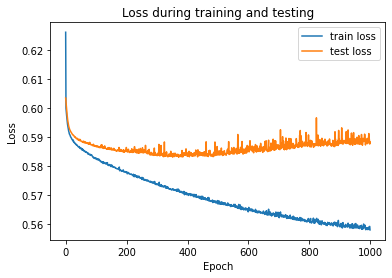

In [ ]:
import matplotlib.pyplot as plt

# set chosen optimization parameters
lr = 0.02
momentum = 0.9
sig_thresh = 0.5

# Make a train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Get dataloaders for training and testing
batch_size = 1000
# Training dataloader will use random batch sampling
train_dataloader_rdm = getBatchLoader(X_train, y_train, batch_size, True)
# Test dataloader will use sequential sampling
test_dataloader = getBatchLoader(X_val, y_val, batch_size, False)

# Reinitialize model and weights
model = NeuralNetwork(66,[32], sigmoid=True).to(device) # send to cpu or gpu
model.apply(weights_init) # Apply weight initialization

# Define torch optimizer
# Stochastic gradient descent optimization with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

best_acc = 0
best_epoch = 0

epochs = 1000

train_losses = []
test_losses = []

# Train and test model
for i in range(epochs):
  # train model
  train_loss, train_accuracy, _, _ = ann_train_batch(train_dataloader_rdm, model, loss_fn, optimizer, sig_thresh)
  # test on test set
  test_loss, test_accuracy, yprob_test, ypred_test = ann_test_batch(test_dataloader, model, sig_thresh)

  train_losses.append(train_loss)
  test_losses.append(test_loss)

  if test_accuracy > best_acc:
        best_acc = test_accuracy
        best_epoch = i

print(f'Best accuracy: {(best_acc*100):>0.2f}% at epoch {best_epoch}')
print(f'Final accuracy: {(test_accuracy*100):>0.2f}% after {epochs} epochs')

# Plot loss during training
plt.plot(train_losses, label ='train loss')
plt.plot(test_losses, label ='test loss')
plt.title('Loss during training and testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Based on the plot above, the test loss starts to increase after about 300-400 epochs, which indicates the model is starting to overfit the training data. Therefore only 300 epochs are needed.

### Tuning the Sigmoid Threshold

See below for tuning of the sigmoid threshold for the final result prediction.

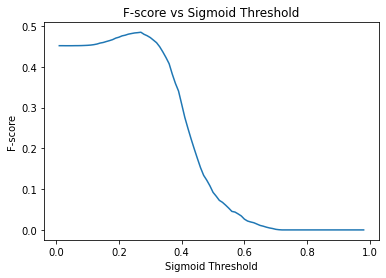

Best F-score: 0.484578840208129 using sig_thresh: 0.27


In [ ]:
# set epochs to 300
epochs = 300
lr = 0.02
momentum = 0.9

# Reinitialize model and weights
model = NeuralNetwork(66,[32], sigmoid=True).to(device) # send to cpu or gpu
model.apply(weights_init) # Apply weight initialization

# Define torch optimizer
# Stochastic gradient descent optimization with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Train and test model
for i in range(epochs):
  # train model
  ann_train_batch(train_dataloader_rdm, model, loss_fn, optimizer, sig_thresh)

# test on test set
test_loss, test_accuracy, yprob_test, ypred_test = ann_test_batch(test_dataloader, model, sig_thresh)

# Test varying thresholds on output probabilities to obtain best f-score
sig_range = np.arange(0.01, 0.99, 0.01)
f_scores = np.zeros_like(sig_range)

for i, sig_thresh in enumerate(sig_range):
    y_pred = yprob_test > sig_thresh

    # Calculate f-score
    # Setting zero_division=0 stops warnings from sklearn when there are
    # divide by zero errors.
    p_score, r_score, f_score, _ = metrics.precision_recall_fscore_support(y_val, y_pred, zero_division=0)
    f_scores[i] = f_score[1]

# Plot F-scores vs sigmoid threshold
plt.plot(sig_range, f_scores)
plt.title('F-score vs Sigmoid Threshold')
plt.xlabel('Sigmoid Threshold')
plt.ylabel('F-score')
plt.show()

best_f = np.amax(f_scores)
best_thresh = sig_range[np.argmax(f_scores)]

print(f'Best F-score: {best_f} using sig_thresh: {best_thresh}')

Based on the above chart, using a threshold of 0.27 on the output of the final sigmoid node produces the best f-score. Note however, that there would be some variability with this as the train-test split may not be balanced between the two classes. It may instead make sense to use the class ratio as the threshold.
The class ratio shown below is the portion of the samples that represent churners.


In [ ]:
class_ratio = y.to_numpy().mean()
print('Class ratio', class_ratio)

Class ratio 0.28949188914458357


We have decided to use the class ratio of 0.29 as the threshold value as we expect this to produce the most consistent result.

## Testing Chosen ANN Params with Cross-Validation

In [ ]:
def ANN_CV_Kfold_5(sampler, sampling, ann_params, X, y, ratio = 1.0):
    # Initialize the lists 
    acc_scores, auc_scores, p_scores, r_scores, f_scores, kf = [], [], [], [], [], 0

    lr = ann_params['lr']
    momentum = ann_params['momentum']
    sig_thresh = ann_params['sig_thresh']
    h_layers = ann_params['h_layers']
    epochs = ann_params['epochs']
    batch_size = ann_params['batch_size']

    # Initialize the Kfolds
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Iterate through Kfold indexes 
    for train_index, test_index in folds.split(X, y):

      # Initialize the data based on Kfold index
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # if sampling apply sampler
      if sampling:
        X_train, y_train = sampler(sampling_strategy=ratio).fit_resample(X_train, y_train)

      # Create dataloaders
      # Training dataloader will use random batch sampling
      train_dataloader_rdm = getBatchLoader(X_train, y_train, batch_size, True)
      # Test dataloader will use sequential sampling
      test_dataloader = getBatchLoader(X_test, y_test, batch_size, False)
      
      # Reinitialize the model for each Kfold
      model = NeuralNetwork(66,h_layers, sigmoid=True).to(device) # send to cpu or gpu
      model.apply(weights_init) # Apply weight initialization

      # Define torch optimizer
      # Stochastic gradient descent optimization with momentum
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

      print('Training')
 
      # Train the model
      for i in range(epochs):
        # train model
        ann_train_batch(train_dataloader_rdm, model, loss_fn, optimizer, sig_thresh)

      print('Predicting')
      
      # test on test set
      test_loss, test_accuracy, y_pred_prob, y_pred = ann_test_batch(test_dataloader, model, sig_thresh)

      print('Obtaining metric')

      p_score, r_score, f_score, _ = metrics.precision_recall_fscore_support(y_test, y_pred)

      # append metric scores to a list 
      acc_scores.append(metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
      auc_scores.append(metrics.roc_auc_score(y_test, y_pred_prob))
      p_scores.append(p_score[1])
      r_scores.append(r_score[1])
      f_scores.append(f_score[1])

      # Print the fold of each loop
      kf += 1
      print('KFold ' + str(kf) + ' completed')

    # return the metric lists, min, max, and mean 
    mean_acc = np.mean(acc_scores)
    mean_auc = np.mean(auc_scores)
    mean_p = np.mean(p_scores)
    mean_r = np.mean(r_scores)
    mean_f = np.mean(f_scores)

    min_acc = np.min(acc_scores)
    min_auc = np.min(auc_scores)
    min_p = np.min(p_scores)
    min_r = np.min(r_scores)
    min_f = np.min(f_scores)

    max_acc = np.max(acc_scores)
    max_auc = np.max(auc_scores)
    max_p = np.max(p_scores)
    max_r = np.max(r_scores)
    max_f = np.max(f_scores)

    # Create Dictionaries of the 5 metrics and their min, mean, max
    acc = {'Accuracy': acc_scores, 'mean' : mean_acc, 'min' : min_acc, 'max' : max_acc}
    auc = {'AUC': auc_scores, 'mean' : mean_auc, 'min' : min_auc, 'max' : max_auc}
    precision = {'Precision': p_scores, 'mean' : mean_p, 'min' : min_p, 'max' : max_p}
    recall = {'Recall': r_scores, 'mean' : mean_r, 'min' : min_r, 'max' : max_r}
    f_score = {'F_score': f_scores, 'mean' : mean_f, 'min' : min_f, 'max' : max_f}

    return acc, auc, precision, recall, f_score

### ANN without Sampling

In [ ]:
# Testing the ANN without undersampling
ann_params = {'lr': 0.02, 'momentum': 0.9, 'epochs':300, 'sig_thresh':0.29, 
              'batch_size':1000, 'h_layers': [32]}

ann_base_metrics = ANN_CV_Kfold_5(None, None, ann_params, X, y)

Training
Predicting
Obtaining metric
KFold 1 completed
Training
Predicting
Obtaining metric
KFold 2 completed
Training
Predicting
Obtaining metric
KFold 3 completed
Training
Predicting
Obtaining metric
KFold 4 completed
Training
Predicting
Obtaining metric
KFold 5 completed


In [ ]:
ann_base_metrics

({'Accuracy': [0.5754923413566739,
   0.5938161795849216,
   0.5922631653254271,
   0.5472257518000847,
   0.5744740928984894],
  'max': 0.5938161795849216,
  'mean': 0.5766543061931193,
  'min': 0.5472257518000847},
 {'AUC': [0.6227763864081068,
   0.6268574795407515,
   0.6276361296052615,
   0.6242631624022008,
   0.6236958429074706],
  'max': 0.6276361296052615,
  'mean': 0.6250458001727582,
  'min': 0.6227763864081068},
 {'Precision': [0.36107480029048655,
   0.37031225482504315,
   0.3702958030044913,
   0.35646022092590296,
   0.3649235945604935],
  'max': 0.37031225482504315,
  'mean': 0.36461333472128354,
  'min': 0.35646022092590296},
 {'Recall': [0.6061936113143136,
   0.5754693977078761,
   0.5830285296269203,
   0.7003169958546696,
   0.6347232382345769],
  'max': 0.7003169958546696,
  'mean': 0.6199463545476712,
  'min': 0.5754693977078761},
 {'F_score': [0.4525760058255962,
   0.4506396792056521,
   0.45292669066111013,
   0.4724461260075671,
   0.4634146341463415],
  'm

### ANN with undersampling

In [ ]:
# Testing the ANN with undersampling
# Note that when undersampling the data, it makes sense to use a sigmoid 
# threshold of 0.5 as the training data is no longer imbalanced
ann_params = {'lr': 0.02, 'momentum': 0.9, 'epochs':300, 'sig_thresh': 0.5, 
              'batch_size':1000, 'h_layers': [32]}

ann_under_metrics = ANN_CV_Kfold_5(RandomUnderSampler, True, ann_params, X, y, ratio = 1.0)

Training
Predicting
Obtaining metric
KFold 1 completed
Training
Predicting
Obtaining metric
KFold 2 completed
Training
Predicting
Obtaining metric
KFold 3 completed
Training
Predicting
Obtaining metric
KFold 4 completed
Training
Predicting
Obtaining metric
KFold 5 completed


In [ ]:
ann_under_metrics

({'Accuracy': [0.5884096844780122,
   0.6137935902866017,
   0.5995340957221517,
   0.5782154454327263,
   0.572850487081745],
  'max': 0.6137935902866017,
  'mean': 0.5905606606002475,
  'min': 0.572850487081745},
 {'AUC': [0.614625209777381,
   0.6110456502376106,
   0.6240149949493132,
   0.6062217871084961,
   0.6142584660327234],
  'max': 0.6240149949493132,
  'mean': 0.6140332216211049,
  'min': 0.6062217871084961},
 {'Precision': [0.36300285080772887,
   0.37568058076225047,
   0.37649277184160906,
   0.3529965484781927,
   0.3552123552123552],
  'max': 0.37649277184160906,
  'mean': 0.36467702142042724,
  'min': 0.3529965484781927},
 {'Recall': [0.5588880760790051,
   0.5047549378200439,
   0.5842477444525725,
   0.548646671543526,
   0.5832723725920507],
  'max': 0.5842477444525725,
  'mean': 0.5559619604974395,
  'min': 0.5047549378200439},
 {'F_score': [0.44013442150744125,
   0.430756424929768,
   0.45790731008122315,
   0.42959427207637235,
   0.44153207198892475],
  'max'

# ANN Hybrid Model

See below for testing of an ANN hybrid structure. This will perform 5-fold cross-validation. For each fold, it will train an ANN and then test on the training data. The correctly predicted values training samples will then be used to train a second ANN, thereby removing outliers from the training data. This second ANN will then be used for the final prediction.

In [ ]:
def ANN_Hybrid_Kfold(sampler, sampling, ann_params, X, y, ratio = 1.0):
    # Initialize the lists 
    acc_scores, auc_scores, p_scores, r_scores, f_scores, kf = [], [], [], [], [], 0

    lr = ann_params['lr']
    momentum = ann_params['momentum']
    sig_thresh = ann_params['sig_thresh']
    h_layers = ann_params['h_layers']
    epochs = ann_params['epochs']
    batch_size = ann_params['batch_size']

    # Initialize the Kfolds
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Iterate through Kfold indexes 
    for train_index, test_index in folds.split(X, y):

      # Initialize the data based on Kfold index
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      # if sampling apply sampler
      if sampling:
        X_train, y_train = sampler(sampling_strategy=ratio).fit_resample(X_train, y_train)

      # Create dataloaders
      # Training dataloader will use random batch sampling
      train_dataloader_rdm = getBatchLoader(X_train, y_train, batch_size, True)
      # This training loader will be sequential so results are in the proper 
      # order when testing on the training set
      train_dataloader = getBatchLoader(X_train, y_train, batch_size, False)
      # Test dataloader will use sequential sampling
      test_dataloader = getBatchLoader(X_test, y_test, batch_size, False)
      
      # Reinitialize the model for each Kfold
      model = NeuralNetwork(66,h_layers, sigmoid=True).to(device) # send to cpu or gpu
      model.apply(weights_init) # Apply weight initialization

      # Define torch optimizer
      # Stochastic gradient descent optimization with momentum
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

      print('Training')
 
      for i in range(epochs):
        # train model
        ann_train_batch(train_dataloader_rdm, model, loss_fn, optimizer, sig_thresh)

      print('Predicting on Train set')
      
      # Test on the training set
      _, _, y_prob_train, y_pred_train = ann_test_batch(train_dataloader, model, sig_thresh)

      # Gather correctly predicted training data
      correct = np.equal(y_train.to_numpy(), y_pred_train)
      
      # Create subset of training set
      X_train2 = X_train.loc[correct]
      y_train2 = y_train.loc[correct]

      print(f'Correctly predicted: {len(y_train2)} / {len(y_train)}')
      print(f'New train churn ratio: {y_train2.to_numpy().mean()}')

      # if sampling apply sampler on subset again
      if sampling:
        X_train2, y_train2 = sampler(sampling_strategy=ratio).fit_resample(X_train2, y_train2)

      train_dataloader2 = getBatchLoader(X_train2, y_train2, batch_size, True)

      # sig_thresh = y_train2.to_numpy().mean()

      print('Training second ANN')

      model2 = NeuralNetwork(66,h_layers, sigmoid=True).to(device) # send to cpu or gpu
      model2.apply(weights_init) # Apply weight initialization

      optimizer2 = torch.optim.SGD(model2.parameters(), lr=lr, momentum=momentum)

      for i in range(epochs):
        # train model
        ann_train_batch(train_dataloader2, model2, loss_fn, optimizer2, sig_thresh)

      print('Predicting on Test set')

      test_loss, test_accuracy, y_pred_prob, y_pred = ann_test_batch(test_dataloader, model2, sig_thresh)

      print('Obtaining metric')

      p_score, r_score, f_score, _ = metrics.precision_recall_fscore_support(y_test, y_pred)

      # append metric scores to a list 
      acc_scores.append(metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
      auc_scores.append(metrics.roc_auc_score(y_test, y_pred_prob))
      p_scores.append(p_score[1])
      r_scores.append(r_score[1])
      f_scores.append(f_score[1])

      # Print the fold of each loop
      kf += 1
      print('KFold ' + str(kf) + ' completed')

    # return the metric lists, min, max, and mean 
    mean_acc = np.mean(acc_scores)
    mean_auc = np.mean(auc_scores)
    mean_p = np.mean(p_scores)
    mean_r = np.mean(r_scores)
    mean_f = np.mean(f_scores)

    min_acc = np.min(acc_scores)
    min_auc = np.min(auc_scores)
    min_p = np.min(p_scores)
    min_r = np.min(r_scores)
    min_f = np.min(f_scores)

    max_acc = np.max(acc_scores)
    max_auc = np.max(auc_scores)
    max_p = np.max(p_scores)
    max_r = np.max(r_scores)
    max_f = np.max(f_scores)

    # Create Dictionaries of the 5 metrics and their min, mean, max
    acc = {'Accuracy': acc_scores, 'mean' : mean_acc, 'min' : min_acc, 'max' : max_acc}
    auc = {'AUC': auc_scores, 'mean' : mean_auc, 'min' : min_auc, 'max' : max_auc}
    precision = {'Precision': p_scores, 'mean' : mean_p, 'min' : min_p, 'max' : max_p}
    recall = {'Recall': r_scores, 'mean' : mean_r, 'min' : min_r, 'max' : max_r}
    f_score = {'F_score': f_scores, 'mean' : mean_f, 'min' : min_f, 'max' : max_f}

    return acc, auc, precision, recall, f_score

## ANN Hybrid Model without Sampling

In [ ]:
# Testing the hybrid ANN without a sampling method
ann_params = {'lr': 0.02, 'momentum': 0.9, 'epochs':300, 'sig_thresh':0.29, 
              'batch_size':1000, 'h_layers': [32]}

hybrid_base_metrics = ANN_Hybrid_Kfold(None, None, ann_params, X, y)

Training
Predicting on Train set
Correctly predicted: 31691 / 56664
New train churn ratio: 0.37158814805465273
Training second ANN
Predicting on Test set
Obtaining metric
KFold 1 completed
Training
Predicting on Train set
Correctly predicted: 31507 / 56665
New train churn ratio: 0.36896562668613325
Training second ANN
Predicting on Test set
Obtaining metric
KFold 2 completed
Training
Predicting on Train set
Correctly predicted: 33636 / 56665
New train churn ratio: 0.30960875252705433
Training second ANN
Predicting on Test set
Obtaining metric
KFold 3 completed
Training
Predicting on Train set
Correctly predicted: 32507 / 56665
New train churn ratio: 0.34706370935490816
Training second ANN
Predicting on Test set
Obtaining metric
KFold 4 completed
Training
Predicting on Train set
Correctly predicted: 34031 / 56665
New train churn ratio: 0.30442831535952514
Training second ANN
Predicting on Test set
Obtaining metric
KFold 5 completed


In [ ]:
hybrid_base_metrics

({'Accuracy': [0.5413990259052728,
   0.540872511647607,
   0.5736269942114923,
   0.5554143724410561,
   0.5511082874488211],
  'max': 0.5736269942114923,
  'mean': 0.5524842383308499,
  'min': 0.540872511647607},
 {'AUC': [0.6187160473622204,
   0.6173720972178766,
   0.6243402642637536,
   0.6185625669190252,
   0.6204554933289628],
  'max': 0.6243402642637536,
  'mean': 0.6198892938183678,
  'min': 0.6173720972178766},
 {'Precision': [0.3527531956735497,
   0.34990630855715177,
   0.3643107067879636,
   0.35604770017035775,
   0.352533960292581],
  'max': 0.3643107067879636,
  'mean': 0.35511037429632075,
  'min': 0.34990630855715177},
 {'Recall': [0.6998293099244087,
   0.6830041453304072,
   0.6347232382345769,
   0.6625213362594489,
   0.6581321628871007],
  'max': 0.6998293099244087,
  'mean': 0.6676420385271885,
  'min': 0.6347232382345769},
 {'F_score': [0.4690692163111875,
   0.4627457459111185,
   0.46292014938644854,
   0.46317763382202526,
   0.4591307306285618],
  'max':

## ANN Hybrid Model with Undersampling

In [ ]:
# Testing the Hybrid ANN with undersampling
# Note that when undersampling the data, it makes sense to use a sigmoid 
# threshold of 0.5 as the training data is no longer imbalanced
ann_params = {'lr': 0.02, 'momentum': 0.9, 'epochs':300, 'sig_thresh': 0.5, 
              'batch_size':1000, 'h_layers': [32]}

hybrid_under_metrics = ANN_Hybrid_Kfold(RandomUnderSampler, True, ann_params, X, y, ratio = 1.0)

Training
Predicting on Train set
Correctly predicted: 19566 / 32808
New train churn ratio: 0.4867116426454053
Training second ANN
Predicting on Test set
Obtaining metric
KFold 1 completed
Training
Predicting on Train set
Correctly predicted: 19798 / 32808
New train churn ratio: 0.5347509849479746
Training second ANN
Predicting on Test set
Obtaining metric
KFold 2 completed
Training
Predicting on Train set
Correctly predicted: 19535 / 32808
New train churn ratio: 0.6505246992577425
Training second ANN
Predicting on Test set
Obtaining metric
KFold 3 completed
Training
Predicting on Train set
Correctly predicted: 19662 / 32808
New train churn ratio: 0.4711626487641135
Training second ANN
Predicting on Test set
Obtaining metric
KFold 4 completed
Training
Predicting on Train set
Correctly predicted: 19844 / 32808
New train churn ratio: 0.5334609957669825
Training second ANN
Predicting on Test set
Obtaining metric
KFold 5 completed


In [ ]:
hybrid_under_metrics

({'Accuracy': [0.591233147455354,
   0.5626147112805309,
   0.48792884371029227,
   0.5863334745164478,
   0.5699562332345052],
  'max': 0.591233147455354,
  'mean': 0.559613282039426,
  'min': 0.48792884371029227},
 {'AUC': [0.6091045502996487,
   0.6132500730135853,
   0.6152109556597066,
   0.610402997439346,
   0.6117192891414293],
  'max': 0.6152109556597066,
  'mean': 0.6119375731107433,
  'min': 0.6091045502996487},
 {'Precision': [0.3625122030589001,
   0.3554175293305728,
   0.3333333333333333,
   0.35761696616480493,
   0.35727598566308244],
  'max': 0.3625122030589001,
  'mean': 0.3532312035101387,
  'min': 0.3333333333333333},
 {'Recall': [0.543282126310656,
   0.6278956352109242,
   0.7688368690563278,
   0.5386491099731773,
   0.6076566691050963],
  'max': 0.7688368690563278,
  'mean': 0.6172640819312363,
  'min': 0.5386491099731773},
 {'F_score': [0.4348589831170099,
   0.45390445972148774,
   0.46504424778761055,
   0.4298501654018292,
   0.44998194293968946],
  'max': 

#XGBoost


In [ ]:
# Necessary libraries 

# Import functions from xgboost and sklearn for opitimization

from xgboost import XGBClassifier
from sklearn import metrics

## XGBoost Hyperparameter Tuning

In [ ]:
# Set a parameter dictionary for the GridSearch, these are just prelimiary 
params = {'n_estimators': [100, 125, 150, 175, 200, 225, 250], 
              'learning_rate': [0.1, 0.01, 0.02, 0.05], 
              'max_depth': [2, 4, 6, 8, 10], 
         }

# Call the model function 
xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'auc')

# Set GridSearch on a cv = 5
xgb_cv_model = GridSearchCV(xgb, params, cv = 5, verbose = 2)

# Fit the Gridsearch model to find the opitmal parameters
xgb_cv_model.fit(X_train_over, y_train_over)

# Print out the best parameter set 
print("Best Parameters : ",xgb_cv_model.best_params_)

In [ ]:
# Best parameter set on the previous cell2cell, learning_rate = 0.05, max_depth = 10, n_estimators = 200

# Will not re-run until data ratio is sorted 

# Fit a model with the ideal parameters
xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'auc', learning_rate = 0.05, max_depth = 10, n_estimators = 200)
xgb.fit(X_train, y_train)

# Predict and show the acc, roc, precision, recall, and fscore 
y_pred = xgb.predict(X_val)
y_pred_prob = xgb.predict_proba(X_val)[:,1]

print('acc:', metrics.accuracy_score(y_true=y_val, y_pred=y_pred))
print('roc auc:', metrics.roc_auc_score(y_val, y_pred_prob))
print('precision, recall, fscore:', metrics.precision_recall_fscore_support(y_val, y_pred))

acc: 0.7208300981153385
roc auc: 0.6815979984864206
precision, recall, fscore: (array([0.7345679 , 0.57332229]), array([0.94867962, 0.16747338]), array([0.82800609, 0.25922457]), array([10035,  4132]))


# XGB Undersampling 1:1 5 Fold

In [ ]:
xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'auc', learning_rate = 0.05, max_depth = 10, n_estimators = 200)
results_xgb = CV_Kfold_5(RandomUnderSampler, False, xgb, X, y, 1)

Fitting
Predicting
Obtaining metric
KFold 1 completed
Fitting
Predicting
Obtaining metric
KFold 2 completed
Fitting
Predicting
Obtaining metric
KFold 3 completed
Fitting
Predicting
Obtaining metric
KFold 4 completed
Fitting
Predicting
Obtaining metric
KFold 5 completed


In [ ]:
results_xgb

({'Accuracy': [0.7199830592221359,
   0.72285754623747,
   0.7203868417337287,
   0.7160807567414937,
   0.7201044755047297],
  'max': 0.72285754623747,
  'mean': 0.7198825358879116,
  'min': 0.7160807567414937},
 {'AUC': [0.6765847842668042,
   0.6778706997542068,
   0.6792240100405641,
   0.6751928727596397,
   0.6748762281938916],
  'max': 0.6792240100405641,
  'mean': 0.6767497190030213,
  'min': 0.6748762281938916},
 {'Precision': [0.5544715447154471,
   0.5720164609053497,
   0.5571895424836601,
   0.5349248452696729,
   0.5597539543057997],
  'max': 0.5720164609053497,
  'mean': 0.555671269535986,
  'min': 0.5349248452696729},
 {'Recall': [0.16630090221897098,
   0.16947086076566692,
   0.16630090221897098,
   0.14752499390392587,
   0.15532796878810046],
  'max': 0.16947086076566692,
  'mean': 0.16098512557912703,
  'min': 0.14752499390392587},
 {'F_score': [0.2558619395985744,
   0.2614747930775019,
   0.25615023474178406,
   0.2312691131498471,
   0.24317617866004962],
  'max

XGB with Undersampling

In [ ]:
({'Accuracy': [0.6175619397190655,
   0.613440632500353,
   0.6179584921643372,
   0.6139347734011013,
   0.6219116193703234],
  'max': 0.6219116193703234,
  'mean': 0.6169614914310361,
  'min': 0.613440632500353},
 {'AUC': [0.6697280998324978,
   0.671495520521148,
   0.6781137190073835,
   0.6712732757679812,
   0.6692056860836167],
  'max': 0.6781137190073835,
  'mean': 0.6719632602425254,
  'min': 0.6692056860836167},
 {'Precision': [0.39911138348398956,
   0.3971885748467175,
   0.4005461993627674,
   0.3973897389738974,
   0.40097838093735205],
  'max': 0.40097838093735205,
  'mean': 0.39904285552094476,
  'min': 0.3971885748467175},
 {'Recall': [0.6352109241648378,
   0.6476469153864911,
   0.6437454279444038,
   0.6459400146305779,
   0.6196049743964887],
  'max': 0.6476469153864911,
  'mean': 0.6384296513045599,
  'min': 0.6196049743964887},
 {'F_score': [0.4902145276627776,
   0.4923989618094179,
   0.49382716049382713,
   0.4920590693786571,
   0.48687488024525766],
  'max': 0.49382716049382713,
  'mean': 0.49107491991798746,
  'min': 0.48687488024525766})

# SVM Undersampling 1:1 5 fold

In [ ]:
svc = SVC(C=4.17, gamma=0.03, kernel='linear', probability=True)
results_svm = CV_Kfold_5(RandomUnderSampler, False, svc, X, y, 1)

Fitting


In [ ]:
({'Accuracy': [0.5848803557563351,
   0.5751800084709868,
   0.5703797825780037,
   0.5775095298602287,
   0.5833686291119582],
  'max': 0.5848803557563351,
  'mean': 0.5782636611555025,
  'min': 0.5703797825780037},
 {'AUC': [0.6132306828576846,
   0.6128685974717131,
   0.6192955978773912,
   0.6141279924819325,
   0.6148409151778982],
  'max': 0.6192955978773912,
  'mean': 0.6148727571733239,
  'min': 0.6128685974717131},
 {'Precision': [0.3629504157684016,
   0.36066288704753596,
   0.3599943574552123,
   0.3615113201999412,
   0.36186531676637523],
  'max': 0.3629504157684016,
  'mean': 0.3613968594474932,
  'min': 0.3599943574552123},
 {'Recall': [0.5747378688124848,
   0.6049743964886612,
   0.6222872470129237,
   0.5996098512557912,
   0.5752255547427457],
  'max': 0.6222872470129237,
  'mean': 0.5953669836625213,
  'min': 0.5747378688124848},
 {'F_score': [0.4449268522888155,
   0.45191256830601084,
   0.45612153708668457,
   0.4510685132532331,
   0.444256120527307],
  'max': 0.45612153708668457,
  'mean': 0.4496571182924102,
  'min': 0.444256120527307})

SVM No Sampling

In [ ]:
({'Accuracy': [0.7104538716736076,
   0.710856981505012,
   0.7117746717492588,
   0.710856981505012,
   0.7105040237187632],
  'max': 0.7117746717492588,
  'mean': 0.7108893060303307,
  'min': 0.7104538716736076},
 {'AUC': [0.5317923649778324,
   0.5030795682731836,
   0.515765374371632,
   0.5522395819516474,
   0.530016051481028],
  'max': 0.5522395819516474,
  'mean': 0.5265785882110647,
  'min': 0.5030795682731836},
 {'Precision': [0.48148148148148145,
   0.5190839694656488,
   0.5833333333333334,
   0.5135135135135135,
   0.5],
  'max': 0.5833333333333334,
  'mean': 0.5194824595587955,
  'min': 0.48148148148148145},
 {'Recall': [0.0031699585466959277,
   0.016581321628871007,
   0.015362106803218726,
   0.02316508168739332,
   0.02365276761765423],
  'max': 0.02365276761765423,
  'mean': 0.016386247256766642,
  'min': 0.0031699585466959277},
 {'F_score': [0.0062984496124031,
   0.032136105860113416,
   0.029935851746258017,
   0.04433037797480168,
   0.045168800931315485],
  'max': 0.045168800931315485,
  'mean': 0.031573917224978335,
  'min': 0.0062984496124031})